# KPrototypes(n=6) Results

From the previous notebook, we have identified that `n=4` is the optimum number of clusters.  
However, there exist a huge cluster `0` which we desire to break up more

**Setting up**

In [1]:
%load_ext kedro.ipython
%load_ext autoreload
%matplotlib inline
%autoreload 2

[04/16/23 18:31:43] INFO     Resolved project path as: /home/eckt/Documents/usg.                    ]8;id=509816;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=861150;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[04/16/23 18:31:46] INFO     Kedro project usg                                                      ]8;id=668654;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=310151;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=760347;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=744004;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

[04/16/23 18:31:48] INFO     Registered line magic 'run_viz'                                        ]8;id=11499;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=907890;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py#110\110]8;;\

In [2]:
import pandas as pd
import polars as pl
import numpy as np

from matplotlib import rc_context
import matplotlib.pyplot as plt
import seaborn as sb
from seaborn.objects import Plot
import seaborn.objects as so

from kmodes.kprototypes import KPrototypes

import logging

from usg.utils import *

log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
sb.set()

In [3]:
X: pd.DataFrame = catalog.load('train')
scaler = catalog.load('model@scaler')

[04/16/23 18:31:49] INFO     Loading data from 'train' (CSVDataSet)...                          ]8;id=346314;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=954132;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py#343\343]8;;\

[04/16/23 18:31:50] INFO     Loading data from 'model@scaler' (PickleDataSet)...                ]8;id=906619;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=67838;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [4]:
def cluster(n=1):
  model = KPrototypes(n_clusters = n, n_jobs = -1, random_state = 0)
  log.info("Performing clustering for n=%d", n)
  y = model.fit_predict(X=X[columns], categorical=list(range(0, len(categorical))))
  log.info("cost[%d]=%.2f", n, model.cost_)
  return model, y

model = None
y = None
if catalog.exists('model@kprototypes@6'):
    model = catalog.load('model@kprototypes@6')
    y = catalog.load('labels@kprototypes@6')
else:
    model, y = cluster(n=6)
    catalog.save('model@kprototypes@6', model)
    catalog.save('labels@kprototypes@6', pd.Series(y, name='cluster'))

X['cluster'] = y

                    INFO     Performing clustering for n=6                                          ]8;id=69262;file:///tmp/ipykernel_3879/3650475112.py\3650475112.py]8;;\:]8;id=382098;file:///tmp/ipykernel_3879/3650475112.py#3\3]8;;\

[04/16/23 18:33:59] INFO     cost[6]=1197.39                                                        ]8;id=805382;file:///tmp/ipykernel_3879/3650475112.py\3650475112.py]8;;\:]8;id=618196;file:///tmp/ipykernel_3879/3650475112.py#5\5]8;;\

                    INFO     Saving data to 'model@kprototypes@6' (PickleDataSet)...            ]8;id=336441;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=409671;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py#382\382]8;;\

                    INFO     Saving data to 'labels@kprototypes@6' (CSVDataSet)...              ]8;id=512078;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=890765;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py#382\382]8;;\

In [5]:
X = X.set_index('appid')
X['cluster'] = X['cluster'].astype(pd.CategoricalDtype(categories=[0,1,2,3,4,5]))

# Centroids

In [6]:
centroids_u = pd.DataFrame(model.cluster_centroids_, columns=numerical+categorical) # KPrototypes handles categorical last
centroids_u

,year,achievements,required_age,price,est_owners,num_categories,num_genres,num_steamspy_tags,positive_ratings,negative_ratings,...,median_playtime,english,windows,mac,linux,Single-player,Multi-player,Indie,Action,Casual
0,0.998883,0.004540,0.000574,0.010972,0.000144,0.118680,0.094671,0.595867,0.000006,0.000019,...,0.000073,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.999082,0.007689,0.000255,0.009808,0.000293,0.134021,0.229774,1.000000,0.000061,0.000081,...,0.000498,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
2,0.998502,0.002135,0.000327,0.017250,0.000847,0.131260,0.133568,1.000000,0.000229,0.000431,...,0.000578,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.998179,0.003236,0.921191,0.029281,0.005465,0.223292,0.156852,0.991243,0.003216,0.003703,...,0.002002,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.998612,0.003254,0.000174,0.014729,0.001054,0.212143,0.172438,0.999869,0.000388,0.000291,...,0.001350,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
5,0.998660,0.003768,0.000308,0.020088,0.002373,0.401606,0.192824,0.996485,0.001222,0.001274,...,0.001233,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0


In [7]:
centroids = pd.DataFrame(scaler.inverse_transform(centroids_u[scaler.feature_names_in_]), columns=scaler.feature_names_in_)
centroids.round(2)

,english,windows,mac,linux,Single-player,Multi-player,Indie,Action,Casual,year,...,price,est_owners,num_categories,num_genres,num_steamspy_tags,positive_ratings,negative_ratings,ratings_ratio,average_playtime,median_playtime
0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2016.75,...,4.63,28882.51,2.14,1.51,1.79,15.57,9.43,2.32,13.45,13.90
1,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,2017.15,...,4.14,58594.04,2.41,3.68,3.00,160.90,39.23,3.76,81.72,94.96
2,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2015.98,...,7.28,169336.22,2.36,2.14,3.00,604.93,209.88,4.58,111.63,110.15
3,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2015.32,...,12.36,1093012.26,4.02,2.51,2.97,8504.74,1803.82,5.71,572.10,381.60
4,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,2016.20,...,6.22,210799.37,3.82,2.76,3.00,1025.83,141.68,6.82,246.12,257.30
5,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,2016.29,...,8.48,474669.81,7.23,3.09,2.99,3231.03,620.77,5.17,278.56,235.02


In [8]:
counts = X['cluster'].value_counts()

viz = centroids_u.reset_index(names='cluster').melt(id_vars='cluster')
viz['categorical'] = viz['variable'].map(lambda x: x in categorical)
centroid_viz_data = (viz
                     .reset_index(names='order')
                     .set_index(['cluster', 'variable'])
                     .join(centroids
                           .reset_index(names='cluster')
                           .melt(id_vars='cluster', value_name='orig')
                           .set_index(['cluster', 'variable'])
                           .round(2)
                     )
                     .reset_index('cluster')
                     .join(X[columns].median()
                           .to_frame('median'),
                           how='left'
                     )
                     .reset_index(names='variable')
                     .set_index('cluster')
                     .sort_values(by='order'))

def centroid_viz(cluster=0):
    df = centroid_viz_data.loc[cluster].reset_index(drop=True)
    return (Plot(data=df, y="variable", x="value", color="categorical")
    .add(so.Bar(width=0.05, color="lightgrey", alpha=0.6), baseline="median", legend=False)
    .add(so.Dot())
    .add(so.Dot(alpha=0.6), x="median")
    .add(so.Text(halign="left", fontsize=8, offset=8, color="black"), text="orig")
    .label(title=f"Visualisation of cluster {cluster} centroid (n={counts[cluster]})")
    .limit(x=(-0.05,1.2)))

In [9]:
cluster_viz_data = X.melt(id_vars='cluster')#.set_index('cluster')

def cluster_viz(cluster=0):
    df = cluster_viz_data.set_index('cluster').loc[cluster].reset_index(drop=True)
    return (sb.catplot(data=df, 
                       x='value', 
                       y='variable', 
                       kind='box', 
                       fliersize=2, 
                       flierprops={"marker": "x"}, 
                       medianprops={"color": "orange"}, 
                       showcaps=False)
            .set(title=f"Visualisation of cluster {cluster} (n={counts[cluster]})"))

## At a glance

**Number of games per cluster**

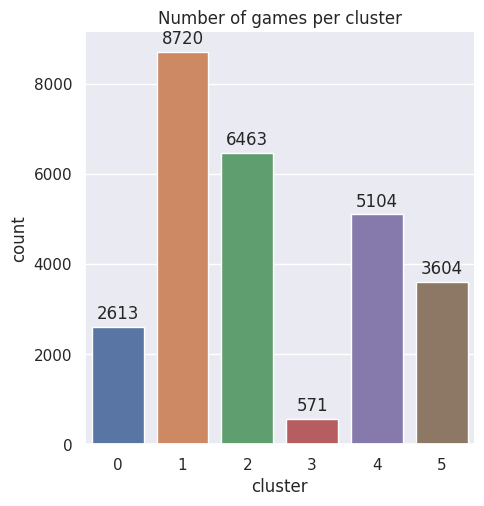

In [10]:
catplot_xlabel(sb.catplot(data=X, x='cluster', kind='count').set(title="Number of games per cluster"))

**Centroid visualisation**

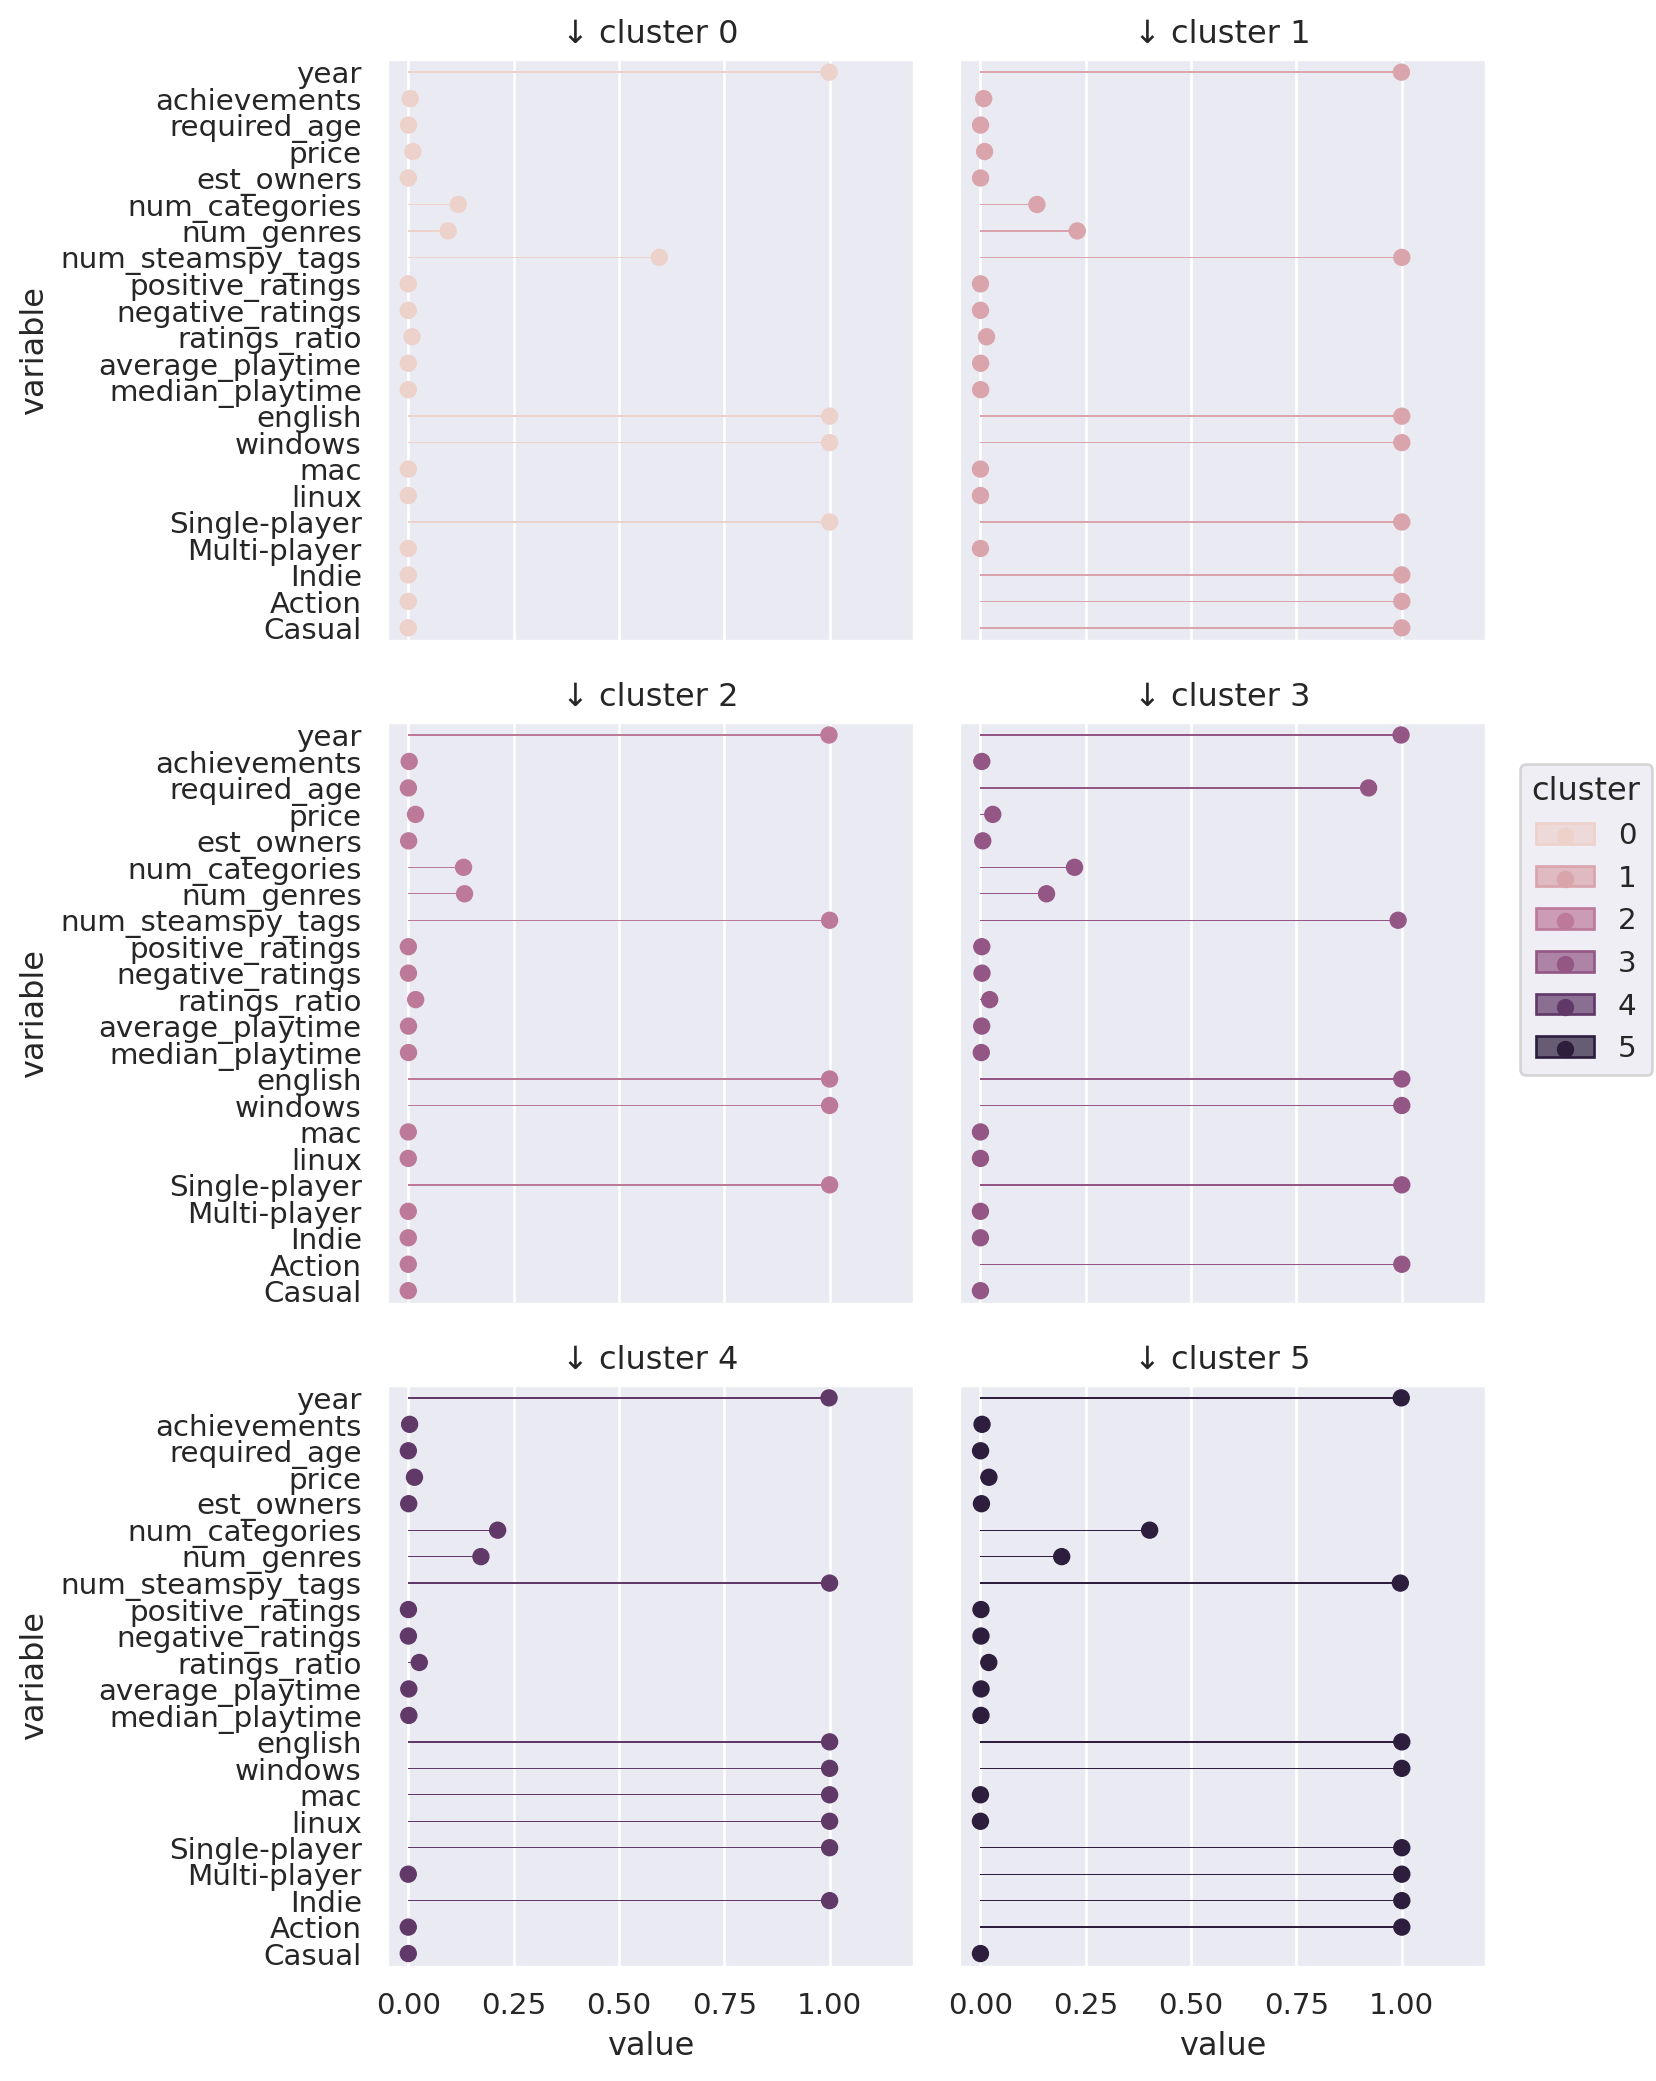

In [22]:
(Plot(data=centroid_viz_data.reset_index(), y="variable", x="value", color="cluster")
 .limit(x=(-0.05,1.2))
 .layout(size=(8,11))
 .facet(col="cluster", wrap=2)
 .add(so.Bar(width=0.05))
 .add(so.Dot())
 .label(col="↓ cluster"))

**Distribution per feature by cluster visualisation**

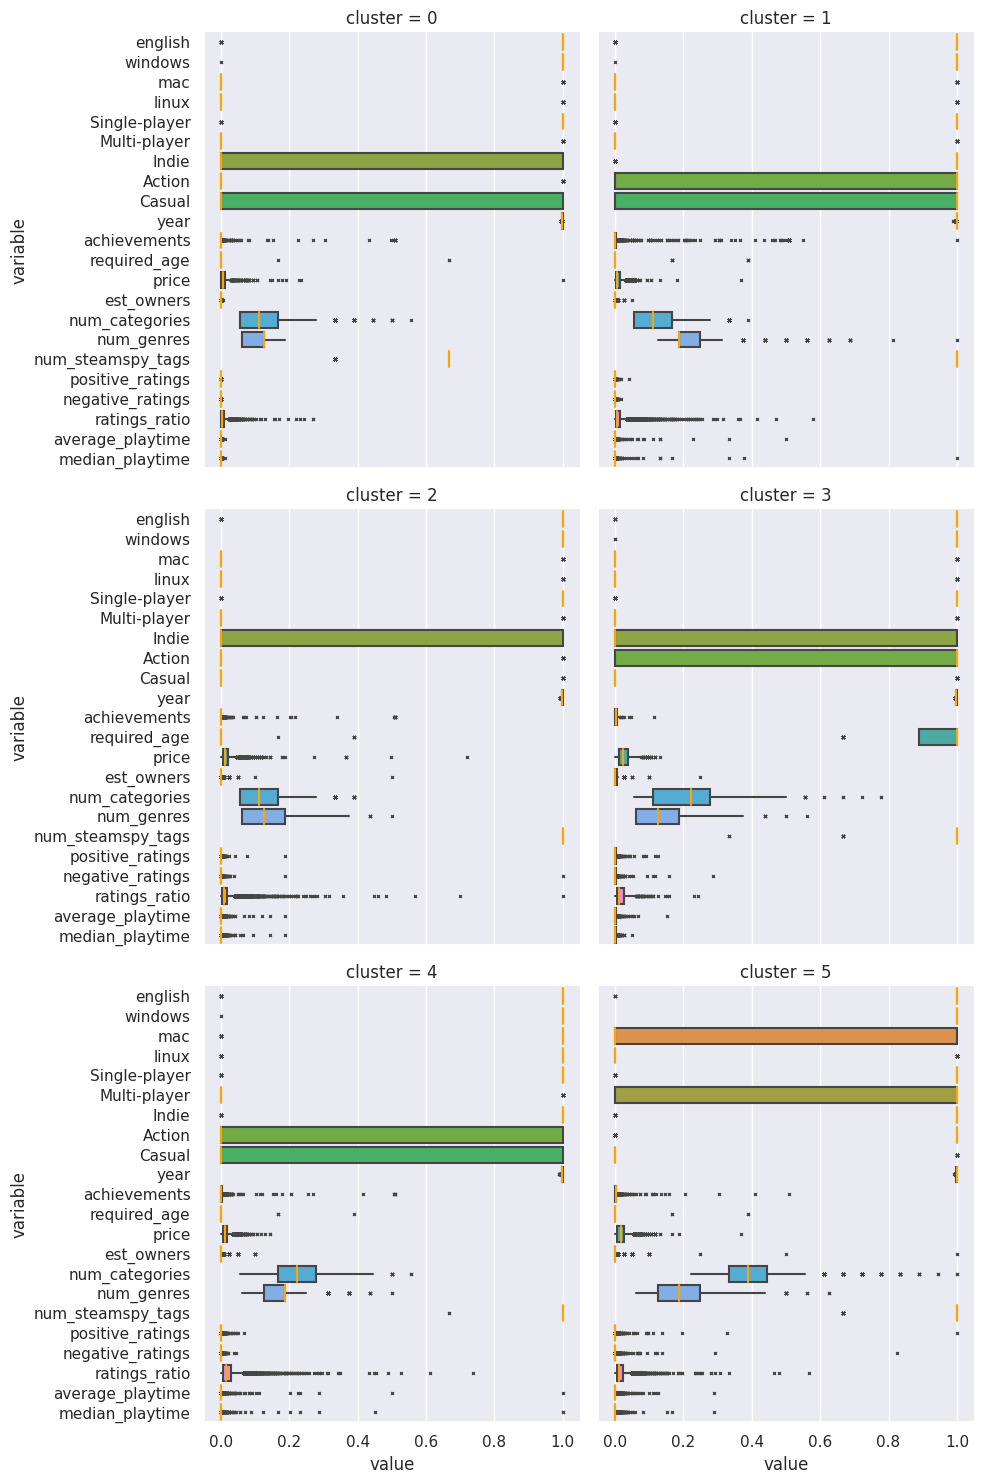

In [12]:
sb.catplot(data=cluster_viz_data, x='value', y='variable', col='cluster', col_wrap=2, kind='box', fliersize=2, flierprops={"marker": "x"}, medianprops={"color": "orange"}, showcaps=False)

# Cluster 0

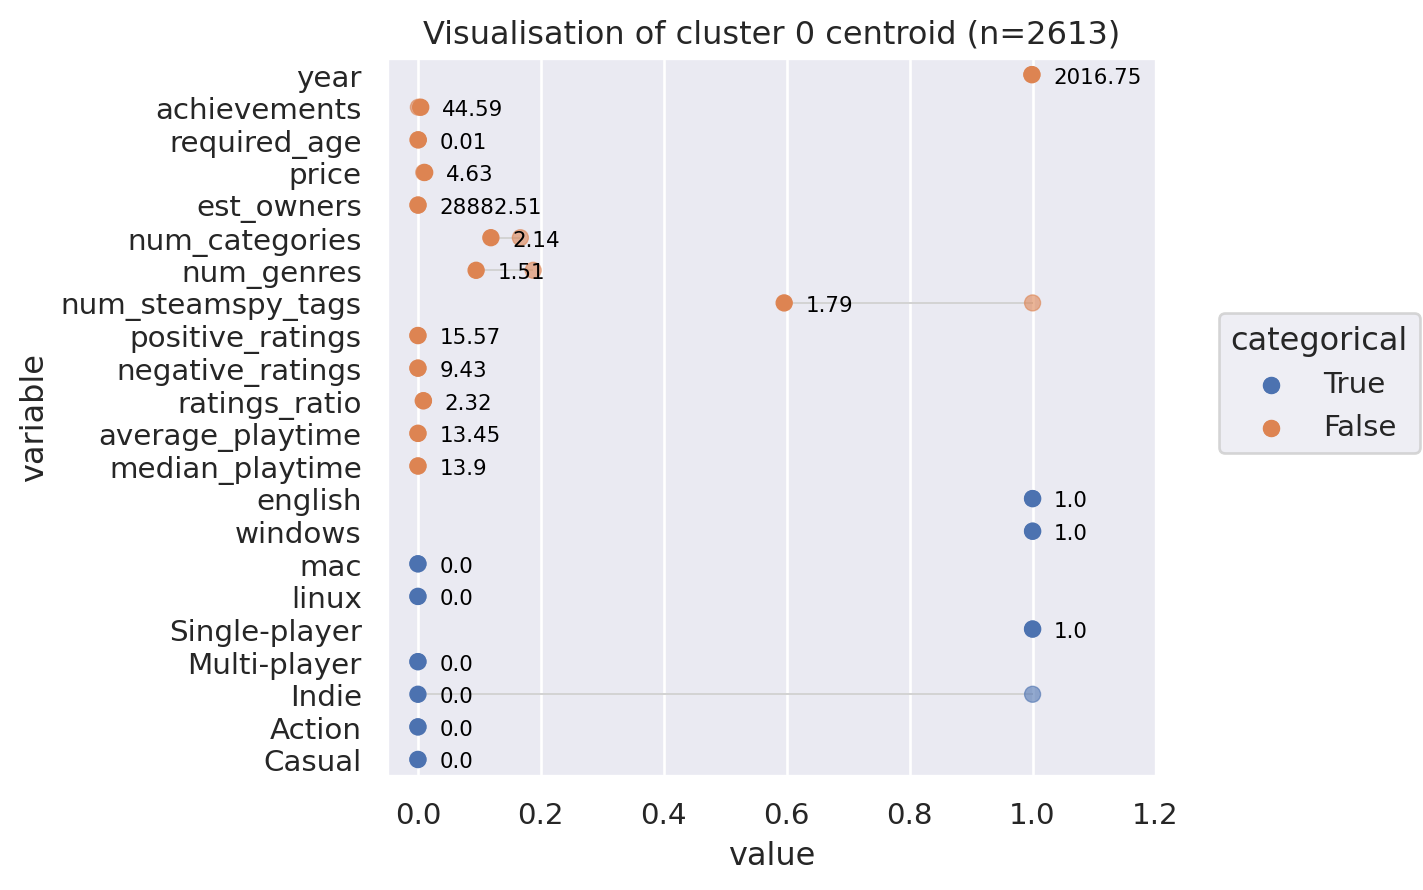

In [13]:
centroid_viz(0)

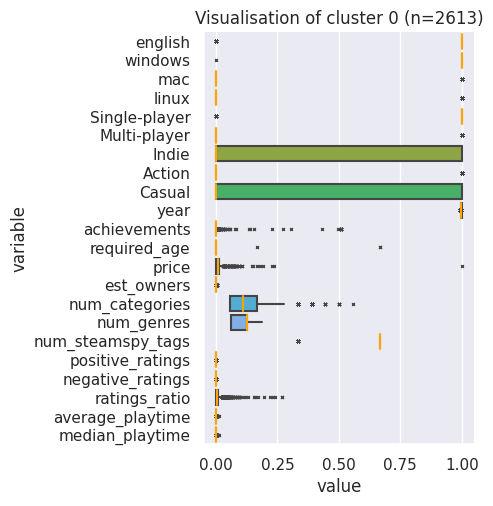

In [14]:
cluster_viz(0)

# Cluster 1

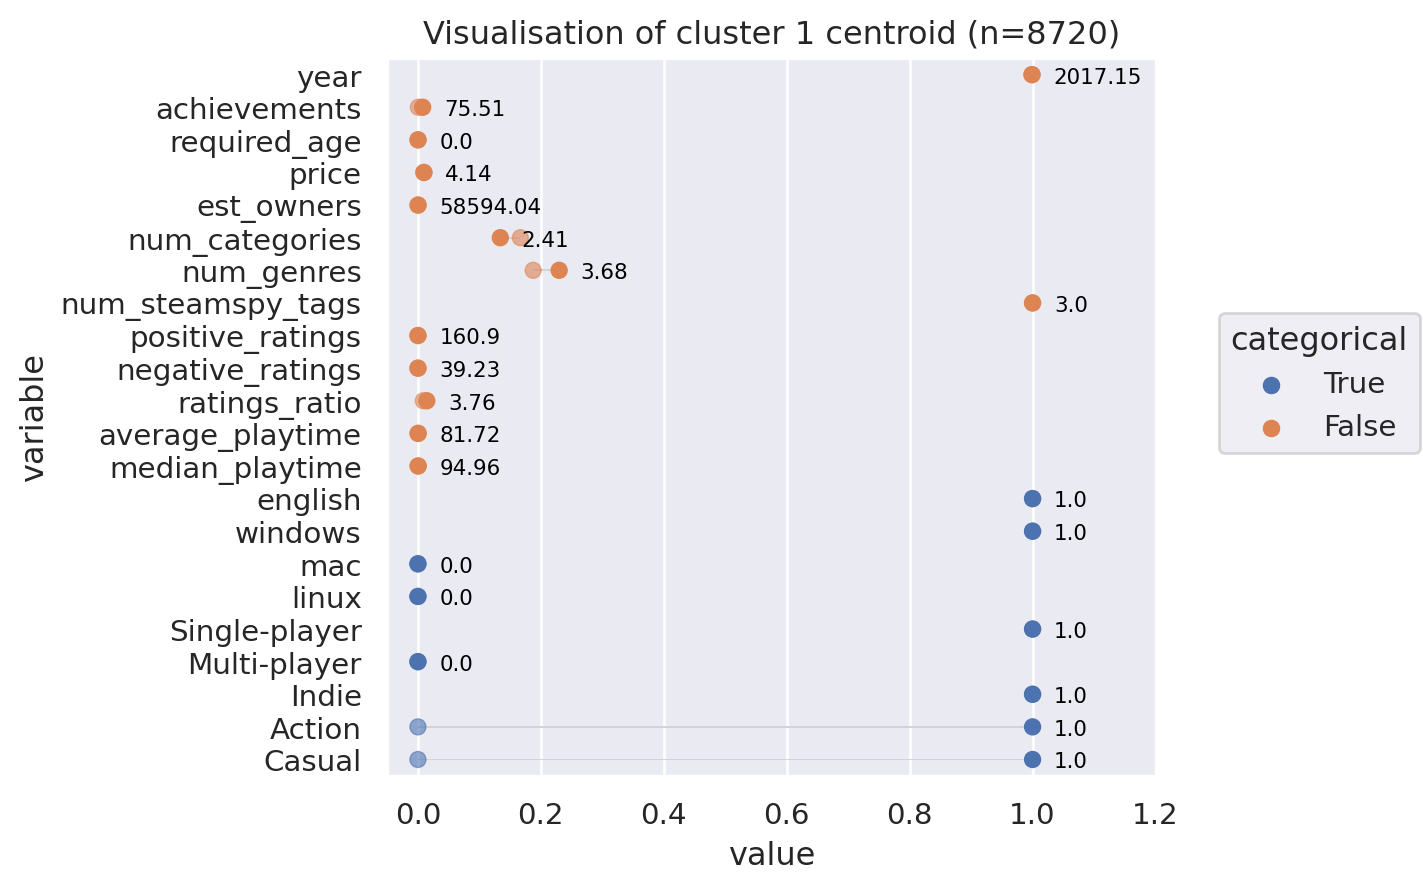

In [15]:
centroid_viz(1)

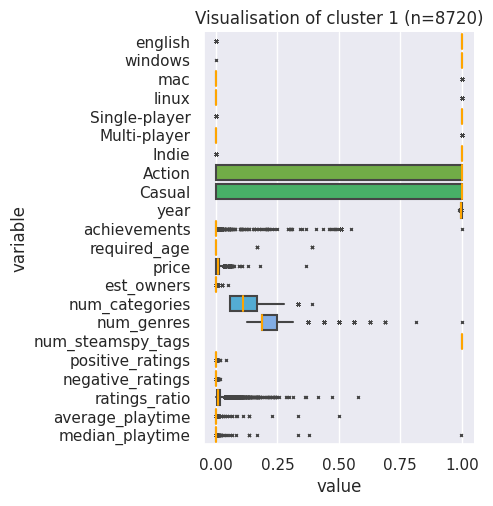

In [16]:
cluster_viz(1)

# Cluster 2

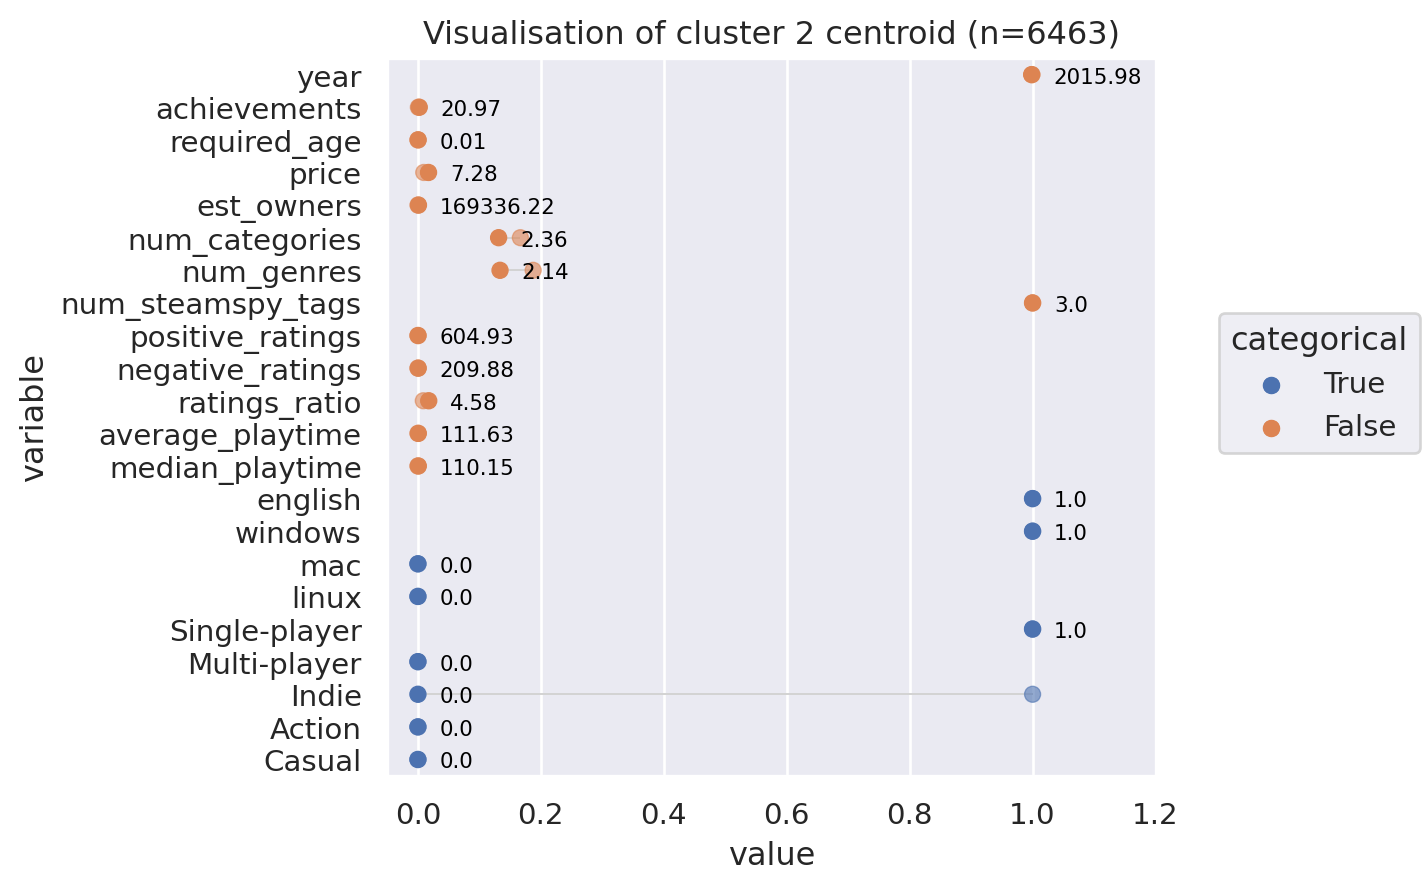

In [17]:
centroid_viz(2)

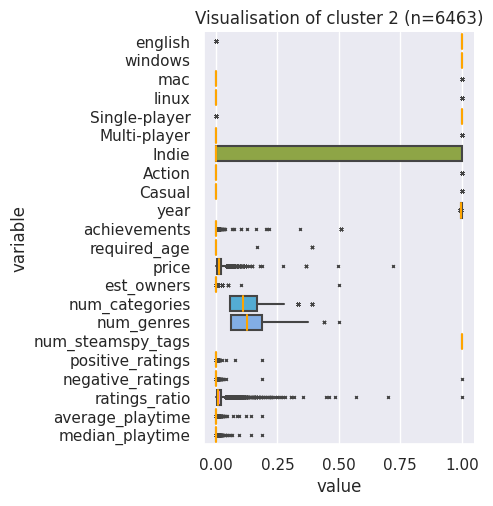

In [18]:
cluster_viz(2)

# Cluster 3

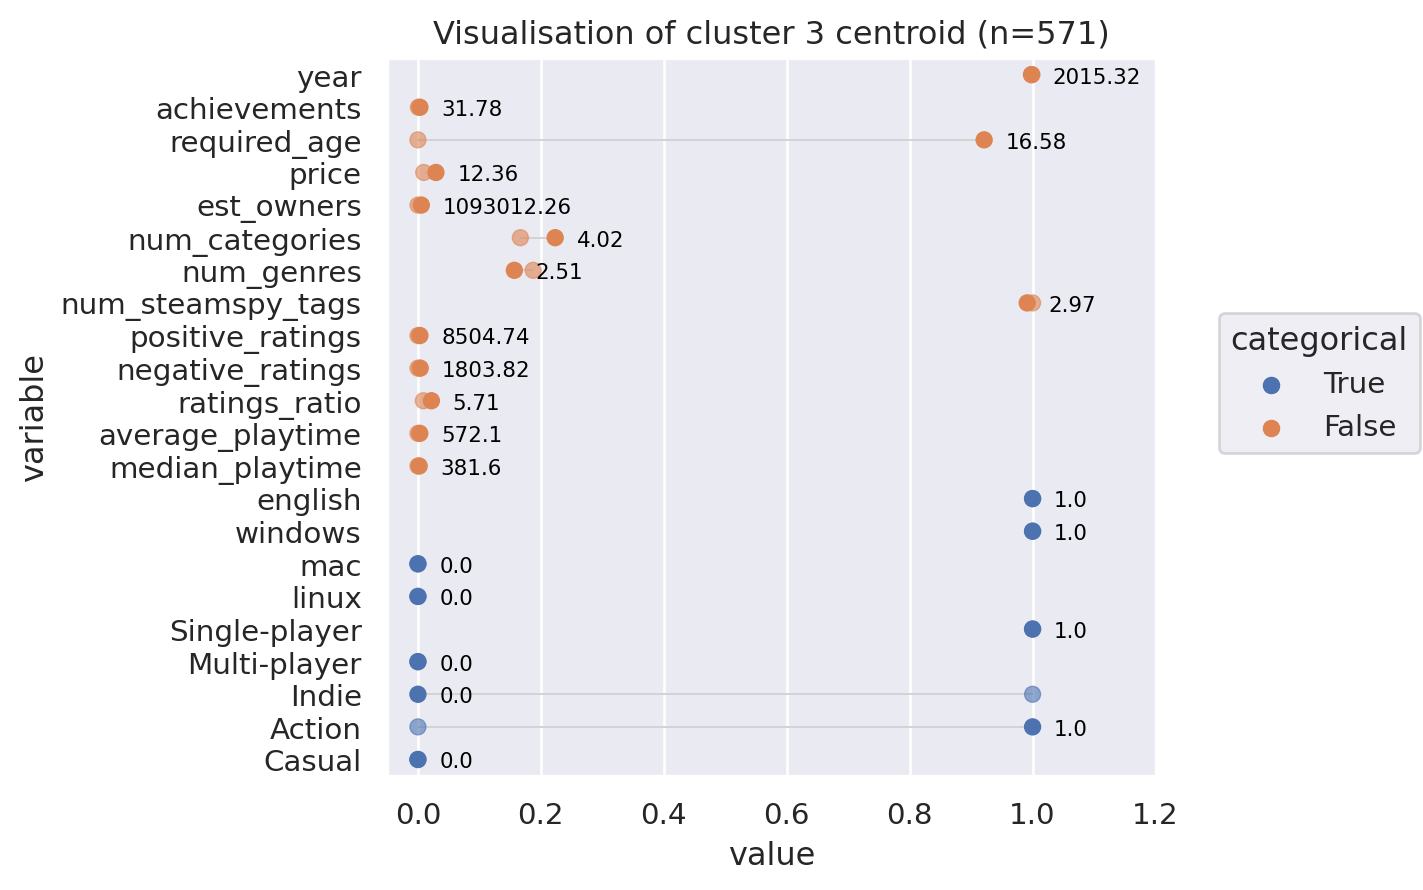

In [19]:
centroid_viz(3)

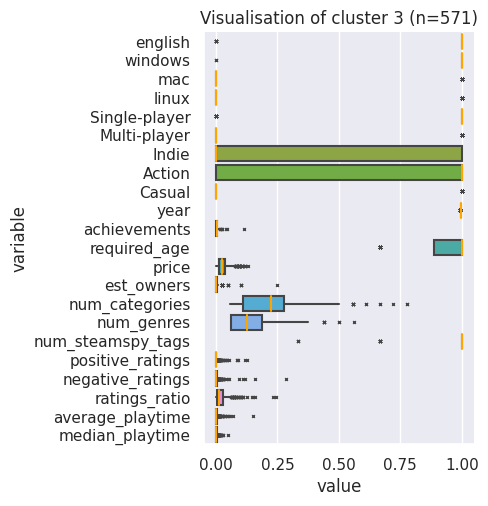

In [20]:
cluster_viz(3)

# Cluster 4

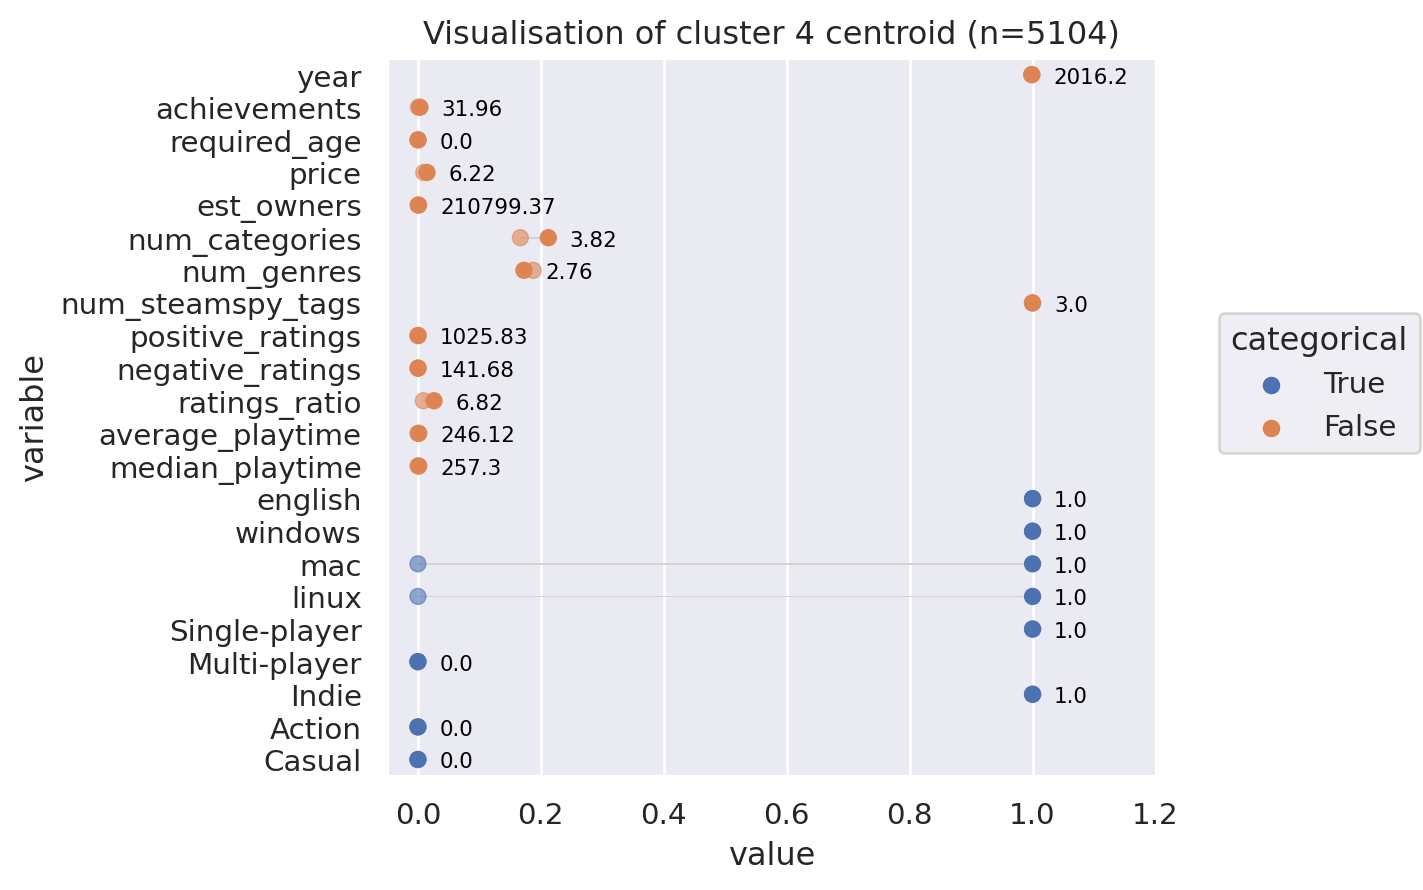

In [23]:
centroid_viz(4)

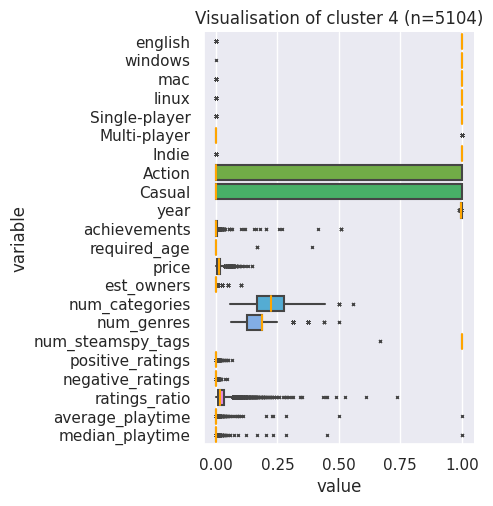

In [24]:
cluster_viz(4)

# Cluster 5

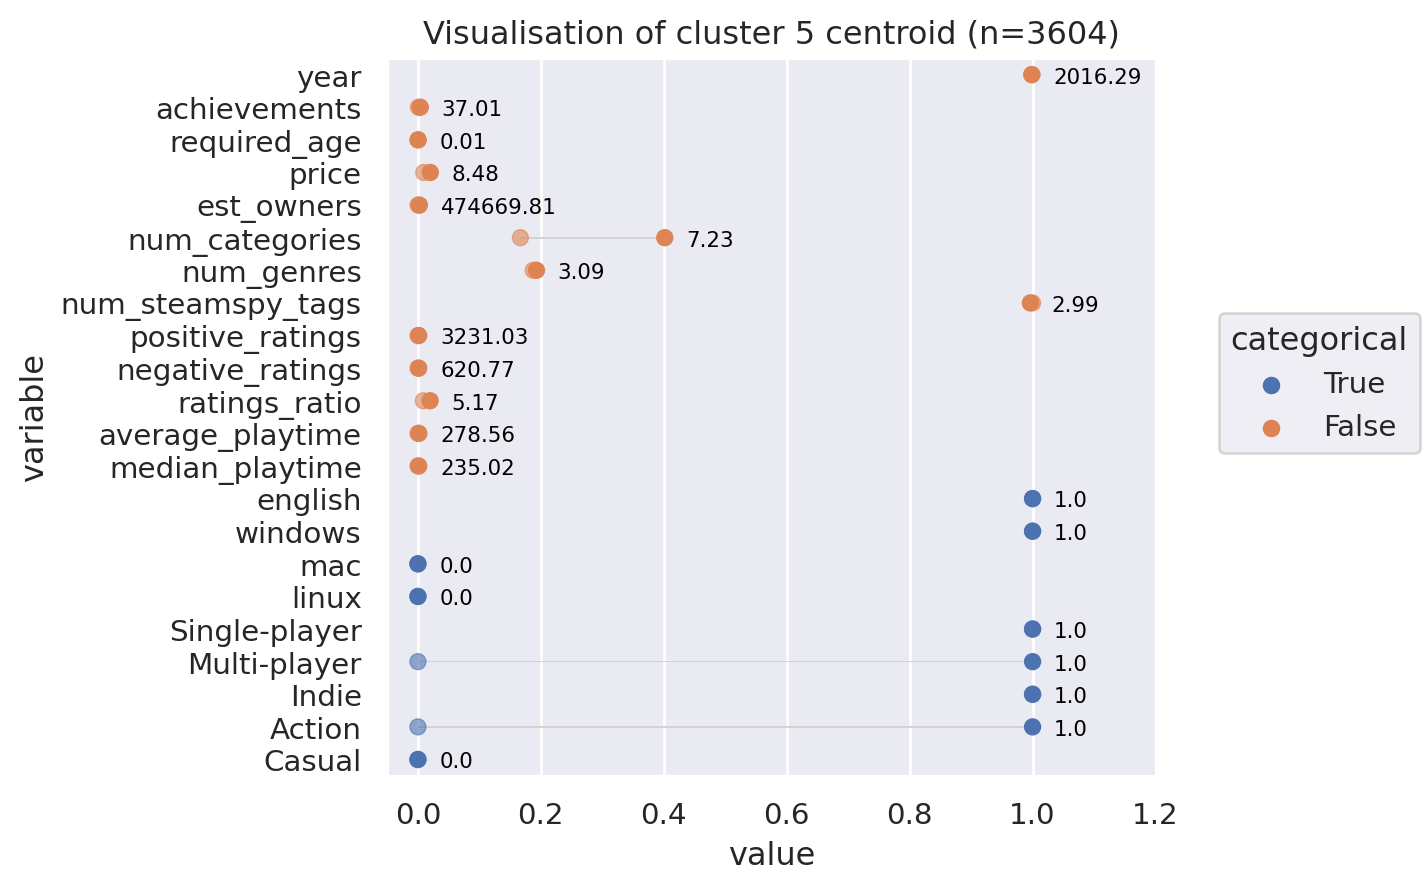

In [25]:
centroid_viz(5)

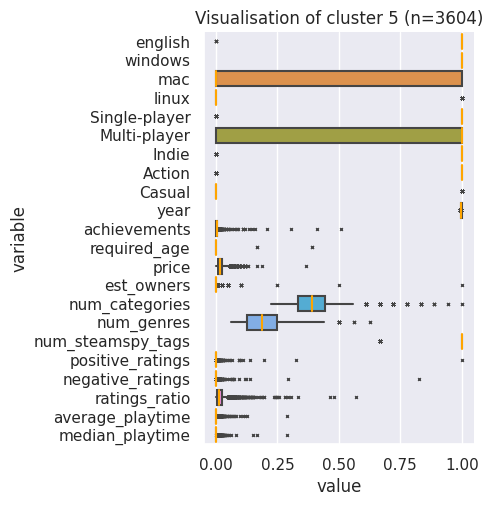

In [26]:
cluster_viz(5)